# 各年のスター獲得数の高いリポジトリ100件を抽出し人気開発言語ランキングを出します

- GitHub API v3

In [1]:
import datetime
# Libraries
import requests
import json
import pprint
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

## original Libraries
import config_manager as cnf
import github_api.github_api_manager as gapi

print("実行日:{0}".format(datetime.datetime.now()))

実行日:2020-09-05 06:52:29.285158


## 抽出の開始年と終了年および上位？件を指定します

### 使い方
- start_year(抽出開始年)を指定します
- end_year(抽出終了年)を指定します
- top(上位X件)を指定します
- configの下にSetting.confがあるので、GitHubへアクセスするためのユーザー名とパスワードを指定します
    - パスワードはアクセスコードでも可

※注1.GitHubはどうやら2007年～のようです。
※注2.GitHub APIへのアクセス回数はユーザーアカウントとパスワード(orアクセスコード)を指定しないと制限されます。

In [2]:
# 抽出の開始年と終了年を指定する
start_year = 2000
end_year = 2020
top = 10

print('------ memo ------')
print('{0}年1月1日 - {1}年12月31日の期間に作成されたリポジトリに対し調査を行います.'.format(start_year,end_year))
print('各年で使用された言語の合計数 TOP{0}のものを個別にグラフ化していきます'.format(top))

# +++++ 下準備 +++++
# コンフィグファイルの読み込み
cnf_data = cnf.confg_manager()
cnf_data.load()
username, userpassword = cnf_data.get_userparam()

# GitHub API v3用のオブジェクト作成
gapi_ctrl = gapi.github_api_manager(username, userpassword)

------ memo ------
2000年1月1日 - 2020年12月31日の期間に作成されたリポジトリに対し調査を行います.
各年で使用された言語の合計数 TOP10のものを個別にグラフ化していきます


## 全期間を通して全言語の一覧とその使用数ランキングを出してみます

In [3]:
# +++++ データの取得とDataFrameへの変換 +++++
df2 = pd.DataFrame()
for year in range(start_year,end_year + 1):

    # create repository api
    github_api = "/search/repositories?q=created:{0}-01-01..{0}-12-31&stars:%3E0&sort=stars&order=desc&page=1&per_page=100".format(year)
    ret_json = gapi_ctrl.get_json(github_api)

    d1 = {}
    for i in range(len(ret_json['items'])):
        # convert dataframe
        d1[i] = ret_json['items'][i]['language']

    df1 = pd.DataFrame(pd.Series(d1).T)
    df1['year'] = year
    df1['count'] = 1


    if len(df2) <= 0:
        df2 = df1
    else:
        df2 = df2.append(df1)

# すべての年で使用言語の合計値を算出する
df_allyear = df2.fillna('None')
df_allyear = df_allyear.reset_index().\
    rename(columns={'index':'index', 0 : 'language'}) \
    .groupby(['language']).sum() \
    .reset_index().sort_values(['count'], ascending=[False]) \
    .reset_index().loc[:,['language','count']]

print('----- memo -----')
print('全期間の言語使用数ランキング(とりあえず省略せずに表示)')
df_allyear

----- memo -----
全期間の言語使用数ランキング(とりあえず省略せずに表示)


,language,count
0,JavaScript,329
1,Python,144
2,None,129
3,Ruby,88
4,Java,79
5,Go,70
6,C++,60
7,TypeScript,58
8,C,40
9,HTML,33


## 上位X件に絞り込みます
注3.Noneはソフトウェアではなくテキストファイルなのでランキングから除外します

In [4]:
print('----- memo -----')
print('TOP{0}に絞る(Noneはソフトウェアではないため除外)'.format(top))

df_allyear_top = df_allyear[lambda d:d['language']!='None'].head(top).reset_index() \
    .loc[:,['language','count']]
df_allyear_top

----- memo -----
TOP10に絞る(Noneはソフトウェアではないため除外)


,language,count
0,JavaScript,329
1,Python,144
2,Ruby,88
3,Java,79
4,Go,70
5,C++,60
6,TypeScript,58
7,C,40
8,HTML,33
9,Shell,30


## 年毎に使用数を並べてみます

In [5]:
# すべての年で使用言語の合計値を算出する
df_yearly = df2.fillna('None')
df_yearly = df_yearly.reset_index().\
    rename(columns={'index':'index', 0 : 'language'}) \
    .groupby(['year','language']).sum() \
    .reset_index().sort_values(['year','count'], ascending=[True,False]) \
    .reset_index().loc[:,['year','count','language']]

df_yearly_disp = df_yearly.pivot(index='language', columns='year',values='count').fillna(0)
pd.options.display.precision = 0
#最大表示列数の指定（ここでは上位X件の言語名とyearのカラム）
print('TOP{0}に対し、言語毎に各年のリポジトリ数を並べる'.format(top))
df_yearly_disp = df_yearly_disp.loc[df_allyear_top['language'],:]
df_yearly_disp

TOP10に対し、言語毎に各年のリポジトリ数を並べる


year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
language,,,,,,,,,,,,,,
JavaScript,0,12,16,43,32,29,34,25,34,28,25,21,14,16
Python,0,6,16,12,8,15,2,4,12,10,17,12,10,20
Ruby,1,48,18,7,4,1,3,2,1,2,0,0,0,1
Java,0,3,5,7,8,11,8,4,1,6,9,9,5,3
Go,0,0,1,0,1,5,14,9,11,5,0,12,7,5
C++,0,2,7,6,2,5,5,7,4,2,5,6,5,4
TypeScript,0,0,1,1,1,1,4,3,9,7,8,4,8,11
C,0,6,5,2,5,4,6,2,1,0,2,0,5,2
HTML,0,2,1,1,3,4,1,1,5,2,3,1,4,5


## 年毎の開発言語使用数の変化を見ます

Text(0.5, 1.0, '言語毎ランキング 上位10言語')

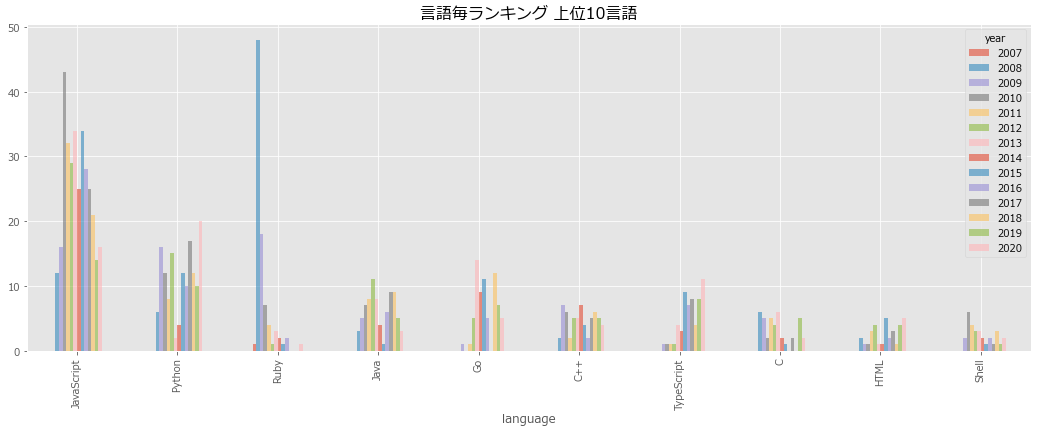

In [6]:

plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)

df_yearly_disp.plot.bar(y=df_yearly_disp.columns.values, alpha=0.6, figsize=(18,6))
plt.title(u'言語毎ランキング 上位{0}言語'.format(top), size=16)